In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from fredapi import Fred
import datetime

# Initialize FRED API
fred = Fred(api_key='8445855393be6d75a6d33bcddffc7958')

In [9]:
# Define the series IDs for the required data
series_ids = {
    '5-Year, 5-Year Forward Inflation Expectation Rate': 'T5YIFR',
    '1 Year Treasury Rate': 'DGS1',
    'fed_balance_sheet_assets': 'WALCL',
    'gdp': 'GDP',
    'Summary of Economic Projections: Longer-Term Federal Funds Rate': 'FEDTARMDLR',
    'US 10yr': 'DGS10'
}

# Fetch the data starting from 11/8/2021
start_date = '2021-11-08'

# Download data and store in a dictionary
data = {name: fred.get_series(series_id, observation_start=start_date) for name, series_id in series_ids.items()}

# Convert the dictionary to a DataFrame
df = pd.DataFrame(data)

# Resample the monthly GDP to daily frequency using forward fill method
df = df.ffill()

# Calculate the Fed Balance Sheet Assets to GDP ratio
df['Fed BS Assets to GDP'] = df['fed_balance_sheet_assets'] / df['gdp']
df = df.drop(['fed_balance_sheet_assets','gdp'], axis=1)
df=df.dropna()
# Display the DataFrame
print(df.tail(5))

            5-Year, 5-Year Forward Inflation Expectation Rate  \
2024-11-20                                               2.27   
2024-11-21                                               2.26   
2024-11-22                                               2.25   
2024-11-25                                               2.23   
2024-11-26                                               2.23   

            1 Year Treasury Rate  \
2024-11-20                  4.37   
2024-11-21                  4.39   
2024-11-22                  4.42   
2024-11-25                  4.37   
2024-11-26                  4.37   

            Summary of Economic Projections: Longer-Term Federal Funds Rate  \
2024-11-20                                                2.9                 
2024-11-21                                                2.9                 
2024-11-22                                                2.9                 
2024-11-25                                                2.9               

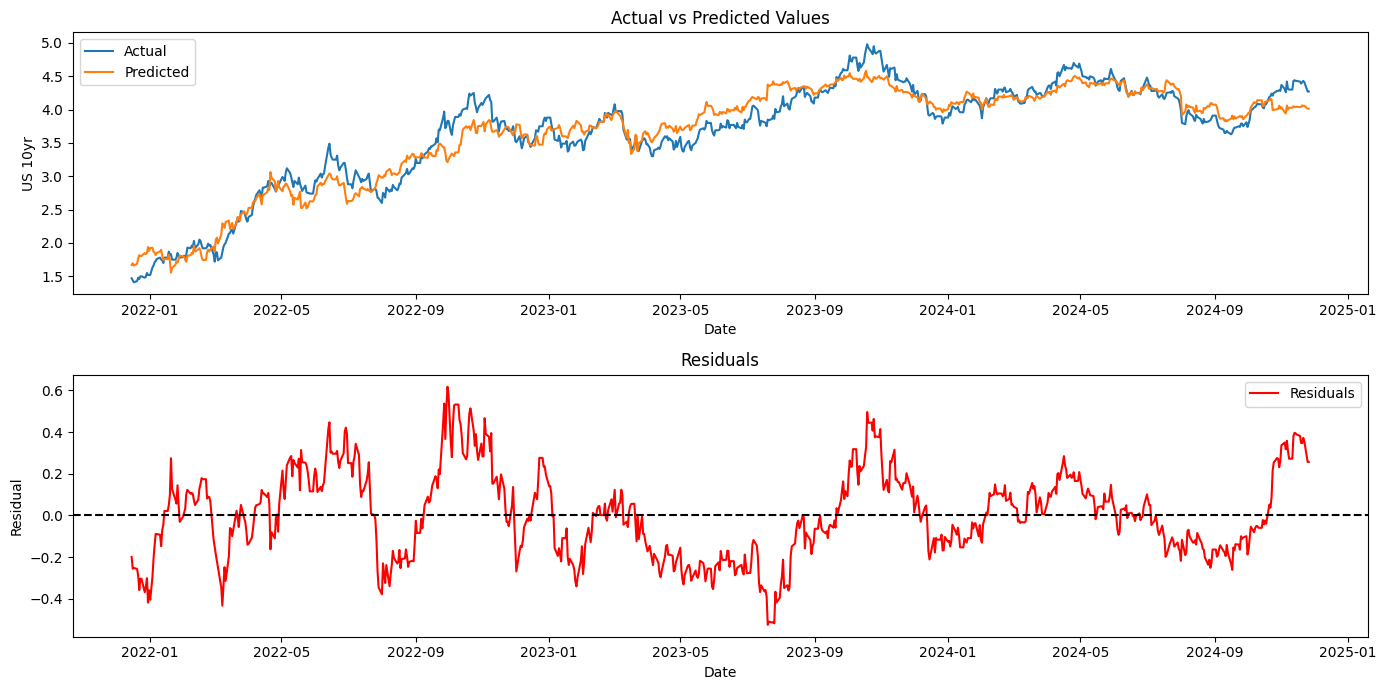

Model Coefficients: [ 1.25056184  0.35732336 -0.00734454 -0.31861493]
Intercept: 2.3191294376031513
R^2: 0.9304450791776814
Current 10-Year Yield: 4.27
Current Prediction: 4.0131
Current Value: 0.2569


In [10]:
from sklearn.linear_model import LinearRegression
import numpy as np

# Convert Date to datetime
df['Date'] = pd.to_datetime(df.index)

# Define predictor variables and target variable
X = df[["5-Year, 5-Year Forward Inflation Expectation Rate", "1 Year Treasury Rate", "Fed BS Assets to GDP", "Summary of Economic Projections: Longer-Term Federal Funds Rate"]]
y = df["US 10yr"]

# Fit linear regression model
model = LinearRegression()
model.fit(X, y)

# Predict values
predictions = model.predict(X)

# Calculate residuals
residuals = y - predictions

# Latest prediction minus latest actual value
latest_diff = y.iloc[-1] - predictions[-1] 

# Output regression information
regression_info = {
    "Intercept": model.intercept_,
    "Coefficients": model.coef_,
    "R^2 Score": model.score(X, y)
}

# Plot actual vs predicted values
plt.figure(figsize=(14, 7))

# Actual vs Predicted
plt.subplot(2, 1, 1)
plt.plot(df['Date'], y, label='Actual', marker='')
plt.plot(df['Date'], predictions, label='Predicted', marker='')
plt.title('Actual vs Predicted Values')
plt.xlabel('Date')
plt.ylabel('US 10yr')
plt.legend()

# Residuals
plt.subplot(2, 1, 2)
plt.plot(df['Date'], residuals, label='Residuals', marker='', color='red')
plt.axhline(y=0, color='black', linestyle='--')
plt.title('Residuals')
plt.xlabel('Date')
plt.ylabel('Residual')
plt.legend()

plt.tight_layout()
plt.show()

# Display regression information and latest difference
#print(regression_info, latest_diff)
print(f"Model Coefficients: {model.coef_}")
print(f"Intercept: {model.intercept_}")
print(f"R^2: {model.score(X,y)}")
print(f"Current 10-Year Yield: {round(y.iloc[-1],4)}")
print(f"Current Prediction: {round(predictions[-1],4)}")
print(f"Current Value: {round(latest_diff,4)}")

In [11]:
df.tail(1)

,"5-Year, 5-Year Forward Inflation Expectation Rate",1 Year Treasury Rate,Summary of Economic Projections: Longer-Term Federal Funds Rate,US 10yr,Fed BS Assets to GDP,Date
2024-11-26,2.23,4.37,2.9,4.27,235.867524,2024-11-26


In [12]:
# make predictions with alternative values
X2 = X.tail(1).copy()
X2.loc[X2.index[0],'Summary of Economic Projections: Longer-Term Federal Funds Rate'] = 3.5
print(model.predict(X2))

[3.82189415]


In [13]:
# make predictions with alternative values
X3 = X.tail(1).copy()
X3.loc[X3.index[0],'Summary of Economic Projections: Longer-Term Federal Funds Rate'] = 2
print(model.predict(X3))

[4.29981654]


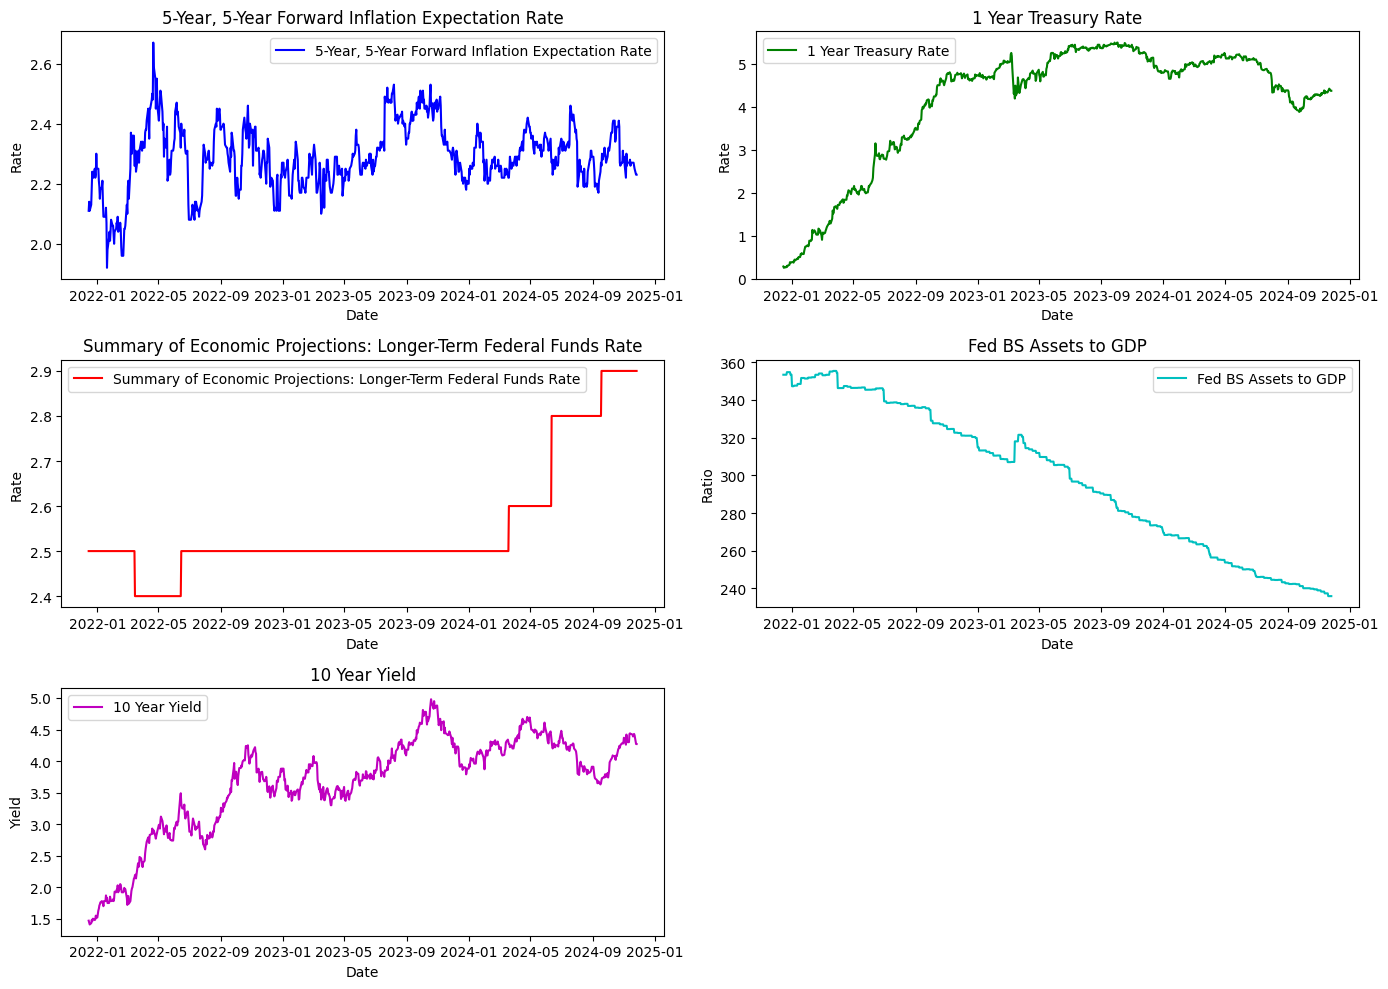

In [14]:
# Plotting the variables
plt.figure(figsize=(14, 10))

# Subplot 1: 5-Year 5-Year Forward Inflation Expectation Rate
plt.subplot(3, 2, 1)
plt.plot(df.index, df['5-Year, 5-Year Forward Inflation Expectation Rate'], label='5-Year, 5-Year Forward Inflation Expectation Rate', color='b')
plt.title('5-Year, 5-Year Forward Inflation Expectation Rate')
plt.xlabel('Date')
plt.ylabel('Rate')
plt.legend()

# Subplot 2: 1 Year Treasury Rate
plt.subplot(3, 2, 2)
plt.plot(df.index, df['1 Year Treasury Rate'], label='1 Year Treasury Rate', color='g')
plt.title('1 Year Treasury Rate')
plt.xlabel('Date')
plt.ylabel('Rate')
plt.legend()

# Subplot 3: US Total Assets Held by All Federal Reserve Banks
plt.subplot(3, 2, 3)
plt.plot(df.index, df['Summary of Economic Projections: Longer-Term Federal Funds Rate'], label='Summary of Economic Projections: Longer-Term Federal Funds Rate', color='r')
plt.title('Summary of Economic Projections: Longer-Term Federal Funds Rate')
plt.xlabel('Date')
plt.ylabel('Rate')
plt.legend()

# Subplot 4: US Monthly GDP
plt.subplot(3, 2, 4)
plt.plot(df.index, df['Fed BS Assets to GDP'], label='Fed BS Assets to GDP', color='c')
plt.title('Fed BS Assets to GDP')
plt.xlabel('Date')
plt.ylabel('Ratio')
plt.legend()

# Subplot 5: 10 Year Yield
plt.subplot(3, 2, 5)
plt.plot(df.index, df['US 10yr'], label='10 Year Yield', color='m')
plt.title('10 Year Yield')
plt.xlabel('Date')
plt.ylabel('Yield')
plt.legend()


# Adjust layout
plt.tight_layout()

# Display the plots
plt.show()